In [1]:
import pandas as pd

# Load the datasets
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')

# Display the first few rows of each dataframe to understand their structure
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [2]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [4]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode user IDs and movie IDs to create compact indices
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings_df['user'] = user_encoder.fit_transform(ratings_df['userId'])
ratings_df['movie'] = movie_encoder.fit_transform(ratings_df['movieId'])

# Prepare the features (user, movie) and target (rating)
X = ratings_df[['user', 'movie']].values
y = ratings_df['rating'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Number of unique users and movies
num_users = ratings_df['user'].nunique()
num_movies = ratings_df['movie'].nunique()

num_users, num_movies

(610, 9724)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(num_users, num_movies, embedding_size=50):
    # Inputs
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')
    
    # User embedding
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
    user_vec = Flatten(name='flatten_users')(user_embedding)
    
    # Movie embedding
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)
    movie_vec = Flatten(name='flatten_movies')(movie_embedding)
    
    # Concatenate the flattened embedding layers
    concat = Concatenate()([user_vec, movie_vec])
    
    # Dense layers
    dense = Dense(128, activation='relu')(concat)
    dense = Dropout(0.5)(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = Dropout(0.5)(dense)
    
    # Output layer
    output = Dense(1)(dense)
    
    # Model
    model = Model(inputs=[user_input, movie_input], outputs=output)
    
    return model

# Build the model
embedding_size = 50
model = build_model(num_users, num_movies, embedding_size)

# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])


model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                30500     ['user_input[0][0]']          
                                                                                                  
 movie_embedding (Embedding  (None, 1, 50)                486200    ['movie_input[0][0]']         
 )                                                                                          

In [7]:
history = model.fit([X_train[:, 0], X_train[:, 1]], y_train, batch_size=32, epochs=5, validation_split=0.1)

Epoch 1/5


2269/2269 [==============================] - 16s 6ms/step - loss: 1.4165 - mae: 0.9265 - val_loss: 0.8242 - val_mae: 0.7127
Epoch 2/5
2269/2269 [==============================] - 14s 6ms/step - loss: 0.9749 - mae: 0.7792 - val_loss: 0.7989 - val_mae: 0.6985
Epoch 3/5
2269/2269 [==============================] - 19s 8ms/step - loss: 0.8352 - mae: 0.7153 - val_loss: 0.7785 - val_mae: 0.6805
Epoch 4/5
2269/2269 [==============================] - 18s 8ms/step - loss: 0.7382 - mae: 0.6669 - val_loss: 0.7656 - val_mae: 0.6769
Epoch 5/5
2269/2269 [==============================] - 33s 15ms/step - loss: 0.6809 - mae: 0.6368 - val_loss: 0.7677 - val_mae: 0.6764


In [8]:
test_loss = model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)

631/631 [==============================] - 2s 4ms/step - loss: 0.7695 - mae: 0.6733


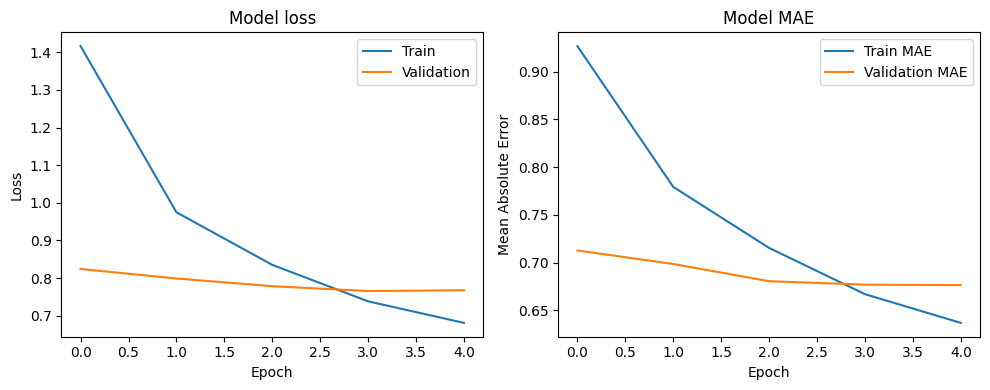

In [9]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of your model.fit() call
# Plot training & validation loss values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [10]:
def predict_rating(user_id, movie_id):
    # Convert user_id and movie_id to the model's expected input format
    user_id_encoded = user_encoder.transform([user_id])
    movie_id_encoded = movie_encoder.transform([movie_id])
    
    # Model prediction
    predicted_rating = model.predict([user_id_encoded, movie_id_encoded])
    
    return predicted_rating[0][0]

# Example: Predict the rating for user with ID 1 and movie with ID 10
predicted_rating = predict_rating(user_id=1, movie_id=10)
print(f"Predicted rating: {predicted_rating}")


1/1 [==============================] - 0s 305ms/step
Predicted rating: 4.064578533172607


In [11]:
import numpy as np

def recommend_movies(user_id, num_recommendations=5):
    # Handle case where the user ID is not seen during training
    if user_id not in user_encoder.classes_:
        print("User ID not seen during training. Returning highest rated movies.")
        # This could be replaced with a more sophisticated approach for new users
        return movies_df.sample(n=num_recommendations)
    
    # Encode the user ID
    user_id_encoded = user_encoder.transform([user_id])
    
    # Movies not rated by the user
    user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId']
    movies_not_rated = movies_df[~movies_df['movieId'].isin(user_rated_movies)]['movieId']
    
    # Filter for movies that are known to the model
    known_movies = movies_not_rated[movies_not_rated.apply(lambda x: x in movie_encoder.classes_)]
    
    if known_movies.empty:
        print("No known movies to recommend for this user.")
        return pd.DataFrame()
    
    # Encode the movie IDs
    movies_not_rated_encoded = movie_encoder.transform(known_movies)
    
    # Predict ratings
    predictions = model.predict([np.array([user_id_encoded] * len(known_movies)), movies_not_rated_encoded])
    
    # Get the top N recommendations
    top_indices = predictions.flatten().argsort()[-num_recommendations:][::-1]
    recommended_movie_ids = known_movies.values[top_indices]
    
    # Get movie titles
    recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]
    
    return recommended_movies


# Example: Recommend 5 movies for user with ID 1
recommendations = recommend_movies(user_id=1, num_recommendations=5)
print(recommendations[['movieId', 'title']])

297/297 [==============================] - 1s 2ms/step
      movieId                                title
895      1192              Paris Is Burning (1990)
1111     1446                 Kolya (Kolja) (1996)
2582     3451  Guess Who's Coming to Dinner (1967)
3505     4789       Phantom of the Paradise (1974)
4396     6460       Trial, The (Procès, Le) (1962)
